In [1]:
import torch
import numpy as np
import pickle
import matplotlib.pyplot as plt

from torchvision import transforms
from scipy.io import loadmat
from tqdm import tqdm

In [2]:
class Randomcrop():
    def __init__(self, length : int):
        self.length = length

    def __call__(self, array : torch.tensor or np.array):
        total_len = array.shape[0]
        start = np.random.randint(low = 0, high = total_len - self.length)
        
        end = start + self.length
        return array[start:end]

class Tensor_and_Norm():
    def __call__(self, array : np.array):
        tensor = torch.FloatTensor(array)
        return torch.nn.functional.normalize(tensor, dim = 0)

In [3]:
class ECG_dataset(torch.utils.data.Dataset):
    def __init__(self, length, pickle_dir):
        self.pickle = pickle.load(open(pickle_dir, 'rb'))
        self.mat_dir = list(self.pickle.keys())
        self.transform = transforms.Compose([
                                            Tensor_and_Norm(),
                                            Randomcrop(length)
                                            ])
    def __len__(self):
        return len(self.pickle.keys())
    
    def __getitem__(self, idx):
        '''
        ecg.shape == batch*length
        '''
        ecg_dir = self.mat_dir[idx]
        ecg = loadmat(ecg_dir)['val'].squeeze()
        ecg = self.transform(ecg)
        cls = torch.FloatTensor([self.pickle[ecg_dir]])

        return ecg, cls
        
ecg_dataset = ECG_dataset(length = 300*10, pickle_dir = './train_dict.pickle')
ecg_loader = torch.utils.data.DataLoader(ecg_dataset, batch_size = 512, shuffle = True,
                                        num_workers = 20, pin_memory = True, drop_last = True)

# https://discuss.pytorch.org/t/how-to-handle-last-batch-in-lstm-hidden-state/40858

In [4]:
class rnn_model(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 2):
        super().__init__()
        self.rnn = torch.nn.RNN(
            input_size = input_size, 
            hidden_size = hidden_size, 
            num_layers = num_layers, 
            batch_first = True,
            nonlinearity = 'tanh',
            bidirectional = False)
            
        self.classifier = torch.nn.Sequential(
            *[  torch.nn.Linear(in_features = 60000, out_features = 1024),
                torch.nn.LayerNorm(1024),
                torch.nn.ReLU(),
                torch.nn.Dropout(p = 0.5),
                torch.nn.Linear(in_features = 1024, out_features = 4),
                torch.nn.LayerNorm(4)
                ]
        )

    def forward(self, h0, input_batch):
        
        features, _ = self.rnn(input_batch, h0)
        features = torch.flatten(features, start_dim = 1)
        logits = self.classifier(features)
        return logits

In [5]:
def batch_acc(output, target):
    correct = 0
    batch_size = output.shape[0]
    for i in range(batch_size):
        if torch.argmax(output[i]).item() == target[i].item():
            correct += 1
    return correct/batch_size

In [6]:
epochs = 20
device = 'cuda:0'
input_size = 1
hidden_size = 20
num_layers = 5
model = rnn_model(input_size, hidden_size, num_layers = num_layers).to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.00001)
h0 = torch.zeros(num_layers,512,hidden_size).to(device)
loss_list = list()
acc_list = list()
for epoch in tqdm(range(epochs)):
    for data in ecg_loader:
        input = data[0].to(device).unsqueeze(dim = 2)
        target = data[1].to(device).squeeze().long()
        
        output = model(h0,input)
        
        train_loss = loss(output, target)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        loss_list.append(train_loss)
        acc_list.append(batch_acc(output, target))
    

100%|██████████| 20/20 [02:20<00:00,  7.04s/it]


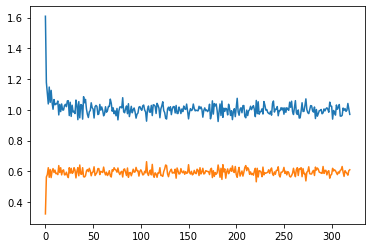

In [7]:
plt.plot([i.cpu().detach().numpy() for i in loss_list])
plt.plot(acc_list)

In [17]:
acc_list[:10]

[0.322265625,
 0.5625,
 0.578125,
 0.623046875,
 0.560546875,
 0.611328125,
 0.55859375,
 0.6015625,
 0.6171875,
 0.591796875]

In [9]:
torch.argmax(output[0])

tensor(0, device='cuda:0')

In [10]:
target[0].item() == torch.argmax(output[0]).item()

True

In [11]:
batch_acc(output, target)

0.609375

In [12]:
[i.cpu().detach().numpy() for i in loss_list][:10]

[array(1.6085763, dtype=float32),
 array(1.1773968, dtype=float32),
 array(1.1087964, dtype=float32),
 array(1.0379381, dtype=float32),
 array(1.147873, dtype=float32),
 array(1.048376, dtype=float32),
 array(1.1263019, dtype=float32),
 array(1.0451868, dtype=float32),
 array(1.0033681, dtype=float32),
 array(1.066449, dtype=float32)]

In [13]:
import torch

batch_size = 3
sesquence = 5
input_size = 7
num_layers = 2
hidden_size = 4

input = torch.randn(sesquence, batch_size, input_size)
h0 = torch.randn(num_layers, batch_size, hidden_size)

rnn = torch.nn.RNN(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = False)

for name , param in rnn.named_parameters():
    print(name, param.shape)

print(f'input : {input.shape}  //  h0 : {h0.shape}')
output, hn = rnn(input, h0)
print(f'output : {output.shape}  //  hn : {hn.shape}')

weight_ih_l0 torch.Size([4, 7])
weight_hh_l0 torch.Size([4, 4])
bias_ih_l0 torch.Size([4])
bias_hh_l0 torch.Size([4])
weight_ih_l1 torch.Size([4, 4])
weight_hh_l1 torch.Size([4, 4])
bias_ih_l1 torch.Size([4])
bias_hh_l1 torch.Size([4])
input : torch.Size([5, 3, 7])  //  h0 : torch.Size([2, 3, 4])
output : torch.Size([5, 3, 4])  //  hn : torch.Size([2, 3, 4])


In [14]:
import torch

batch_size = 3
sesquence = 5000
input_size = 7
num_layers = 2
hidden_size = 400

input = torch.randn(sesquence, batch_size, input_size)
h0 = torch.randn(num_layers, batch_size, hidden_size)

rnn = torch.nn.RNN(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = False)

for name , param in rnn.named_parameters():
    print(name, param.shape)

print(f'input : {input.shape}  //  h0 : {h0.shape}')
output, hn = rnn(input, h0)
print(f'output : {output.shape}  //  hn : {hn.shape}')

weight_ih_l0 torch.Size([400, 7])
weight_hh_l0 torch.Size([400, 400])
bias_ih_l0 torch.Size([400])
bias_hh_l0 torch.Size([400])
weight_ih_l1 torch.Size([400, 400])
weight_hh_l1 torch.Size([400, 400])
bias_ih_l1 torch.Size([400])
bias_hh_l1 torch.Size([400])
input : torch.Size([5000, 3, 7])  //  h0 : torch.Size([2, 3, 400])
output : torch.Size([5000, 3, 400])  //  hn : torch.Size([2, 3, 400])


In [15]:
output[-1].unsqueeze(dim = 0)

tensor([[[-0.0143,  0.1410,  0.0486,  ..., -0.0728,  0.1508,  0.0805],
         [ 0.0367,  0.1143,  0.0452,  ...,  0.1085, -0.0165,  0.0078],
         [-0.1132,  0.0425,  0.0727,  ..., -0.0457,  0.0765, -0.0054]]],
       grad_fn=<UnsqueezeBackward0>)

In [16]:
hn

tensor([[[-0.0540, -0.1535,  0.0580,  ..., -0.0255,  0.1007,  0.0551],
         [ 0.0462, -0.0488, -0.0095,  ...,  0.1287, -0.0189,  0.0955],
         [-0.0530,  0.0258,  0.0165,  ...,  0.0416, -0.0599,  0.1078]],

        [[-0.0143,  0.1410,  0.0486,  ..., -0.0728,  0.1508,  0.0805],
         [ 0.0367,  0.1143,  0.0452,  ...,  0.1085, -0.0165,  0.0078],
         [-0.1132,  0.0425,  0.0727,  ..., -0.0457,  0.0765, -0.0054]]],
       grad_fn=<StackBackward>)

In [3]:
import torch
torch.nn.LSTM(
            input_size = 1, 
            hidden_size = 1, 
            num_layers = 1, 
            batch_first = True,
            nonlinearity = 'relu',
            bidirectional = False)
            

LSTM(1, 1, batch_first=True)